In [1]:
import pandas as pd
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster.elbow import kelbow_visualizer
%matplotlib inline

c:\users\alicia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
divs_data_original = pd.read_csv('./dataframes/df_skyscanner.csv', index_col=0)

In [3]:
divs_data_original

,xpath,reduced_xpath,dom_tree_level,x_position,y_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,is_search_result
0,/html/body/div[1],/html/body/div[],3,0,0,4362.266602,1349.0,1831,2,0,0,0.0,0,0,0,0,0,False
1,/html/body/div[1]/div[1]/div/div[1],/html/body/div[]/div[]/div/div[],6,0,470,216.000000,1349.0,12,1,0,0,0.0,0,0,0,0,0,False
2,/html/body/div[1]/div[1]/div/div[1]/div,/html/body/div[]/div[]/div/div[]/div,7,0,470,216.000000,1349.0,11,1,0,24,0.0,24,0,0,0,0,False
3,/html/body/div[1]/div[1]/div/div[1]/div/div[1],/html/body/div[]/div[]/div/div[]/div/div[],8,146,506,110.000000,88.0,2,2,0,0,0.0,0,0,0,0,0,False
4,/html/body/div[1]/div[1]/div/div[1]/div/div[1]...,/html/body/div[]/div[]/div/div[]/div/div[]/div,9,146,506,110.000000,88.0,1,2,0,0,110.0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,22,610,4012,93.899994,252.0,1,1,0,0,0.0,0,0,6,0,0,False
180,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,17,1072,3964,240.000000,192.0,4,1,18,18,18.0,18,0,0,0,0,False
181,/html/body/div[1]/div[3]/div/div[3],/html/body/div[]/div[]/div/div[],6,0,4246,116.000000,1349.0,14,1,0,0,0.0,0,0,0,0,0,False
182,/html/body/div[1]/div[3]/div/div[3]/div,/html/body/div[]/div[]/div/div[]/div,7,84,4246,116.000000,1180.0,13,1,0,0,0.0,0,0,0,0,0,False


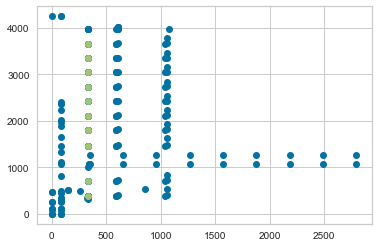

In [4]:
# Gráfica con la posición de cada uno de los elementos donde aquellos
# que son resultados de búsqueda se muestran con un color distinto
groups = divs_data_original.groupby("is_search_result")
for name, group in groups:
    plt.plot(group["x_position"], group["y_position"], marker="o", linestyle="", label=name)

In [5]:
# Agrupamos los datos según si son resultados de búsqueda o no, para ver un resumen de sus características
divs_data_original.groupby(divs_data_original['is_search_result'], as_index=False).mean().sort_values(by='width', ascending=False)

,is_search_result,dom_tree_level,x_position,y_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left
1,True,15.000000,330.000000,2162.50000,301.299988,934.000000,80.200000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
0,False,15.781609,579.890805,1785.62069,488.468573,514.169445,125.425287,1.08046,4.241379,2.862069,14.404598,2.862069,0.724138,0.344828,0.517241,0.241379


In [6]:
# Comprobamos cuántos resultados de búsqueda hay en el dataframe original, antes de eliminar ninguna fila
total_items = len(divs_data_original[divs_data_original['is_search_result'] == 1])
print("Resultados de búsqueda en el dataframe original: " + str(total_items))

Resultados de búsqueda en el dataframe original: 10


In [7]:
divs_data = divs_data_original

# Subdividir cada conjunto con el mismo "reduced_xpath" según el número de "html_attributes"
# y eliminar las subdivisiones que tengan menos de 8 elementos
for x in set(divs_data['reduced_xpath']):
    print('----------- REDUCED XPATH ' + str(x) + ' -----------')
    df = divs_data[divs_data['reduced_xpath'] == x]
    for y in set(df['html_attributes']):
        df2 = df[df['html_attributes'] == y]
        index = df2.index
        number_of_rows = len(index)
        print('----------- ' + str(y) + ' HTML ATTRIBUTES: ' + str(number_of_rows) + ' ELEMENTO/S -----------')
        print(df2)
        
        if number_of_rows < 8:
            divs_data = divs_data.drop(df2.index)

----------- REDUCED XPATH /html/body/div[]/div[]/div/div[]/div/div/div -----------
----------- 1 HTML ATTRIBUTES: 1 ELEMENTO/S -----------
                                              xpath  \
17  /html/body/div[1]/div[3]/div/div[1]/div/div/div   

                                   reduced_xpath  dom_tree_level  x_position  \
17  /html/body/div[]/div[]/div/div[]/div/div/div               9          84   

    y_position  height   width  html_children  html_attributes  padding_top  \
17         114   132.0  1180.0             30                1            0   

    padding_right  padding_bottom  padding_left  margin_top  margin_right  \
17              0             0.0             0           0             0   

    margin_bottom  margin_left  is_search_result  
17              0            0             False  
----------- REDUCED XPATH /html/body/div[]/div[]/div/div[]/div -----------
----------- 1 HTML ATTRIBUTES: 3 ELEMENTO/S -----------
                                       xpa

60           0             0              0            0             False  
----------- REDUCED XPATH /html/body/div[]/div[]/div/div[]/div[]/div/div[]/div/div[]/div[] -----------
----------- 1 HTML ATTRIBUTES: 4 ELEMENTO/S -----------
                                                xpath  \
30  /html/body/div[1]/div[3]/div/div[2]/div[2]/div...   
33  /html/body/div[1]/div[3]/div/div[2]/div[2]/div...   
39  /html/body/div[1]/div[3]/div/div[2]/div[2]/div...   
42  /html/body/div[1]/div[3]/div/div[2]/div[2]/div...   

                                        reduced_xpath  dom_tree_level  \
30  /html/body/div[]/div[]/div/div[]/div[]/div/div...              12   
33  /html/body/div[]/div[]/div/div[]/div[]/div/div...              12   
39  /html/body/div[]/div[]/div/div[]/div[]/div/div...              12   
42  /html/body/div[]/div[]/div/div[]/div[]/div/div...              12   

    x_position  y_position  height  width  html_children  html_attributes  \
30          84         494   306.0 

In [8]:
divs_data

,xpath,reduced_xpath,dom_tree_level,x_position,y_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,is_search_result
27,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,11,84,340,98.000000,228.000000,26,1,0,0,0.0,0,0,0,0,0,False
29,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,11,84,444,356.000000,228.000000,63,1,18,0,0.0,0,6,0,0,0,False
31,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,11,84,806,260.000000,228.000000,87,1,18,0,0.0,0,6,0,0,0,False
32,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,11,84,1072,260.000000,228.000000,52,1,18,0,0.0,0,6,0,0,0,False
34,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,11,84,1338,116.000000,228.000000,19,1,18,0,0.0,0,6,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,17,592,3645,306.799988,672.483337,38,2,0,0,0.0,0,0,0,0,0,False
164,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,18,592,3645,306.799988,438.483337,13,1,12,12,12.0,12,0,0,0,0,False
166,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,18,1042,3645,306.799988,222.000000,20,1,12,12,12.0,12,0,0,0,0,False
167,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,20,1054,3663,198.800003,192.000000,13,1,0,0,0.0,0,0,0,0,0,False


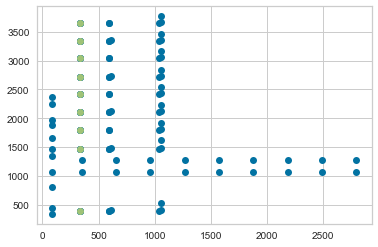

In [9]:
# Gráfica con la posición de cada uno de los elementos donde aquellos
# que son resultados de búsqueda se muestran con un color distinto
groups = divs_data.groupby("is_search_result")
for name, group in groups:
    plt.plot(group["x_position"], group["y_position"], marker="o", linestyle="", label=name)

In [10]:
# Comprobamos cuántos resultados de búsqueda hay en el dataframe, tras eliminar conjuntos de menos de 8 elementos
print("Resultados de búsqueda tras eliminar conjuntos de menos de 8 elementos: " + str(len(divs_data[divs_data['is_search_result'] == 1])))

Resultados de búsqueda tras eliminar conjuntos de menos de 8 elementos: 9


In [11]:
# Eliminamos los campos que no son númericos (xpath, reduced_xpath), la clasificación correcta (is_search_result)
# y la "posición y" (y_position) ya que varía mucho entre resultados de búsqueda al ser un listado vertical. 
divs_data_r = divs_data.drop(['xpath', 'reduced_xpath', 'is_search_result', 'y_position'], axis=1)
scaler = MinMaxScaler()
# Estandarización de todos los valores numéricos
divs_data_r[['dom_tree_level', 'x_position', 'height', 'width', 'html_children', 'html_attributes', 'padding_top', 'padding_right', 'padding_bottom', 'padding_left', 'margin_top', 'margin_right', 'margin_bottom', 'margin_left']] = scaler.fit_transform(divs_data_r[['dom_tree_level', 'x_position', 'height', 'width', 'html_children', 'html_attributes', 'padding_top', 'padding_right', 'padding_bottom', 'padding_left', 'margin_top', 'margin_right', 'margin_bottom', 'margin_left']])
divs_data_r

,dom_tree_level,x_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left
27,0.0,0.000000,0.065217,0.048518,0.221154,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
29,0.0,0.000000,1.000000,0.048518,0.576923,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
31,0.0,0.000000,0.652174,0.048518,0.807692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
32,0.0,0.000000,0.652174,0.048518,0.471154,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
34,0.0,0.000000,0.130435,0.048518,0.153846,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.6,0.187316,0.821739,0.647552,0.336538,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
164,0.7,0.187316,0.821739,0.332188,0.096154,0.0,0.666667,0.666667,0.059524,0.666667,0.0,0.0,0.0,0.0
166,0.7,0.353245,0.821739,0.040431,0.163462,0.0,0.666667,0.666667,0.059524,0.666667,0.0,0.0,0.0,0.0
167,0.9,0.357670,0.430435,0.000000,0.096154,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


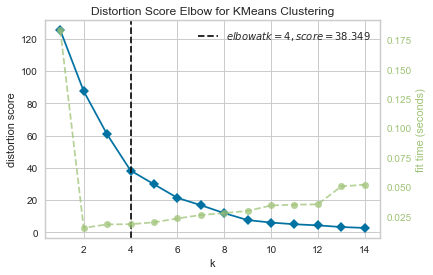

c:\users\alicia\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [12]:
# Gráfica del elbow method para determinar el número de clusters en kmeans
kelbow_visualizer(KMeans(random_state=4), divs_data_r, k=(1,15))

In [13]:
# Calculamos automáticamente el codo de la gráfica
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(divs_data_r)
    Sum_of_squared_distances.append(km.inertia_)
    
kn = KneeLocator(K, Sum_of_squared_distances, curve='convex', direction='decreasing')

In [14]:
# Ejecución del algoritmo kmeans con el k anteriormente calculado
model = KMeans(n_clusters=kn.knee)
model.fit(divs_data_r)
yhat = model.predict(divs_data_r)

# Añadimos al dataframe "y_position" estandarizada para poder representar los puntos
divs_data_r['y_position'] = divs_data['y_position']
scaler = MinMaxScaler()
divs_data_r[['y_position']] = scaler.fit_transform(divs_data_r[['y_position']])
# Añadimos una nueva columna "cluster" que indique a qué cluster ha sido asignado cada elemento
divs_data_r['cluster'] = yhat

In [15]:
divs_data_r

,dom_tree_level,x_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,y_position,cluster
27,0.0,0.000000,0.065217,0.048518,0.221154,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1
29,0.0,0.000000,1.000000,0.048518,0.576923,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.030338,0
31,0.0,0.000000,0.652174,0.048518,0.807692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.135939,0
32,0.0,0.000000,0.652174,0.048518,0.471154,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.213536,0
34,0.0,0.000000,0.130435,0.048518,0.153846,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.291132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.6,0.187316,0.821739,0.647552,0.336538,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.964119,2
164,0.7,0.187316,0.821739,0.332188,0.096154,0.0,0.666667,0.666667,0.059524,0.666667,0.0,0.0,0.0,0.0,0.964119,3
166,0.7,0.353245,0.821739,0.040431,0.163462,0.0,0.666667,0.666667,0.059524,0.666667,0.0,0.0,0.0,0.0,0.964119,3
167,0.9,0.357670,0.430435,0.000000,0.096154,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.969370,1


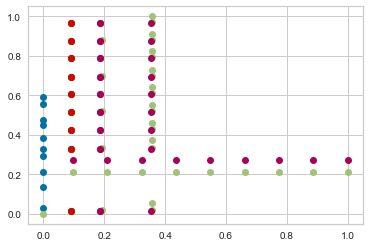

In [16]:
# Gráfica con la posición de cada uno de los elementos coloreados
# según el cluster al que pertenecen
groups = divs_data_r.groupby("cluster")
for name, group in groups:
    plt.plot(group["x_position"], group["y_position"], marker="o", linestyle="", label=name)

In [17]:
# Recuperamos las columnas "xpath" y "reduced_path" para continuar con el filtrado
divs_data_r['xpath'] = divs_data['xpath']
divs_data_r['reduced_xpath'] = divs_data['reduced_xpath']
# Recuperamos la columna "is_search_result" para comprobar los resultados
divs_data_r['is_search_result'] = divs_data['is_search_result']
# Datos agrupados según su cluster, donde podemos ver un resumen de sus características
divs_data_r.groupby(divs_data_r['cluster'], as_index=False).mean().sort_values(by='width', ascending=False)

,cluster,dom_tree_level,x_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,y_position,is_search_result
2,2,0.500000,0.122911,0.804428,0.882517,0.701923,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.0,0.578569,0.333333
3,3,0.766667,0.363078,0.643733,0.167333,0.216880,0.000000,0.777778,0.777778,0.069444,0.777778,0.000000,0.0,0.000000,0.0,0.476144,0.000000
1,1,0.847059,0.274090,0.503268,0.085453,0.078243,0.000000,0.000000,0.000000,0.176471,0.000000,0.088235,0.0,0.000000,0.0,0.501544,0.000000
0,0,0.000000,0.000000,0.479710,0.048518,0.414423,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.345099,0.000000


In [18]:
# Guarda los números de aquellos clusters con std = 0 en la columna 
# "y_position" (es decir, misma y), para posteriormente eliminarlos
delete = []

# Para aquellos clusters que contengan más de un "reduced_xpath"
# distinto, nos quedamos únicamente con el más corto.
for x in set(divs_data_r['cluster']):
    print('----------- CLUSTER ' + str(x) + ' -----------')
    df = divs_data_r[divs_data_r['cluster'] == x]
    xpath = len(set(df['reduced_xpath']))
    
    if (xpath > 1):
        df_drop = df[df['reduced_xpath'] != min(list(df['reduced_xpath']), key=len)]
        df = df.drop(df_drop.index)
        divs_data_r = divs_data_r.drop(df_drop.index)
        
    print(df['reduced_xpath'].value_counts())
    
    std = df.std(axis = 0, skipna = True)
    print("std['y_position'] == " + str(std['y_position']))
    
    if (std['y_position'] == 0):
        delete.append(x)

----------- CLUSTER 0 -----------
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div/div[]    10
Name: reduced_xpath, dtype: int64
std['y_position'] == 0.1815320886976978
----------- CLUSTER 1 -----------
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div/div[]    1
Name: reduced_xpath, dtype: int64
std['y_position'] == nan
----------- CLUSTER 2 -----------
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div[]/div/div/div[]/section[]/div    9
Name: reduced_xpath, dtype: int64
std['y_position'] == 0.2965724928051422
----------- CLUSTER 3 -----------
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div[]/div/div/div[]/section[]/div/div/div/div[]    18
Name: reduced_xpath, dtype: int64
std['y_position'] == 0.28771757964431405


In [19]:
print("Clusters a eliminar con std['y_position'] == 0: " + str(delete))
# Eliminamos clusters cuyos elementos tengan la misma "y"
for i in delete:
    divs_data_r = divs_data_r[divs_data_r.cluster != i] 

Clusters a eliminar con std['y_position'] == 0: []


In [20]:
# Comprobamos cuántos resultados de búsqueda hay en el dataframe, tras eliminar conjuntos cuyo xpath no es el más corto del cluster
print("Resultados de búsqueda tras eliminar conjuntos cuyo xpath no es el más corto del cluster: " + str(len(divs_data_r[divs_data_r['is_search_result'] == 1])))

Resultados de búsqueda tras eliminar conjuntos cuyo xpath no es el más corto del cluster: 9


In [21]:
divs_data_r

,dom_tree_level,x_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,y_position,cluster,xpath,reduced_xpath,is_search_result
27,0.0,0.000000,0.065217,0.048518,0.221154,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
29,0.0,0.000000,1.000000,0.048518,0.576923,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.030338,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
31,0.0,0.000000,0.652174,0.048518,0.807692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.135939,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
32,0.0,0.000000,0.652174,0.048518,0.471154,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.213536,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
34,0.0,0.000000,0.130435,0.048518,0.153846,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.291132,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
35,0.0,0.000000,0.391304,0.048518,0.307692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.326721,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
36,0.0,0.000000,0.521739,0.048518,0.432692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.383314,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
37,0.0,0.000000,0.000000,0.048518,0.076923,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.450408,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
38,0.0,0.000000,0.666667,0.048518,0.682692,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.475496,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False
40,0.0,0.000000,0.130435,0.048518,0.163462,0.0,1.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.554259,0,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,False


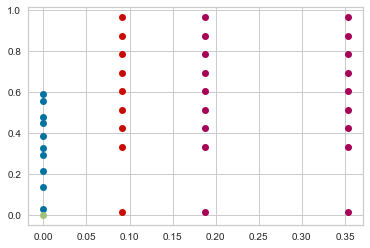

In [22]:
# Gráfica con la posición de cada uno de los elementos coloreados
# según el cluster al que pertenecen
groups = divs_data_r.groupby("cluster")
for name, group in groups:
    plt.plot(group["x_position"], group["y_position"], marker="o", linestyle="", label=name)

In [23]:
# Mostramos todos los "reduced_xpath" distintos del dataframe y su número de ocurrencias
print(divs_data_r['reduced_xpath'].value_counts())

/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div[]/div/div/div[]/section[]/div/div/div/div[]    18
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div/div[]                                          11
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div[]/div/div/div[]/section[]/div                   9
Name: reduced_xpath, dtype: int64


In [24]:
# Nos quedamos con el cluster cuyo "reduced_xpath" esté contenido en el mayor
# número de los otros "reduced_xpath", es decir "el xpath padre"
xpath_list = list(divs_data_r['reduced_xpath'])

apariciones = 0
xpath_res = ''

for x in xpath_list:
    contador = -1
    
    for y in xpath_list:
        
        if x in y:
            contador += 1
    
    if xpath_res == '' and apariciones == 0:
        xpath_res = x
        apariciones = contador
    
    elif contador > apariciones:
        xpath_res = x
        apariciones = contador

print("--------------- REDUCED_XPATH ESCOGIDO COMO SOLUCIÓN ---------------")
print(xpath_res)

--------------- REDUCED_XPATH ESCOGIDO COMO SOLUCIÓN ---------------
/html/body/div[]/div[]/div/div[]/div[]/div/div[]/div[]/div/div/div[]/section[]/div


In [25]:
df_res = divs_data_r[divs_data_r['reduced_xpath'] == xpath_res]
df_res

,dom_tree_level,x_position,height,width,html_children,html_attributes,padding_top,padding_right,padding_bottom,padding_left,margin_top,margin_right,margin_bottom,margin_left,y_position,cluster,xpath,reduced_xpath,is_search_result
48,0.4,0.090708,0.863406,1.0,0.903846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.013127,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
89,0.4,0.090708,0.863406,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.329055,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
99,0.4,0.090708,0.756522,1.0,0.673077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.425613,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
109,0.4,0.090708,0.821739,1.0,0.740385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.513127,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
119,0.4,0.090708,0.756522,1.0,0.644231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.606184,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
129,0.4,0.090708,0.821739,1.0,0.759615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.693991,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
139,0.4,0.090708,0.756522,1.0,0.701923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.787048,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
149,0.4,0.090708,0.778261,1.0,0.817308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.874854,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True
159,0.4,0.090708,0.821739,1.0,0.451923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.964119,2,/html/body/div[1]/div[3]/div/div[2]/div[2]/div...,/html/body/div[]/div[]/div/div[]/div[]/div/div...,True


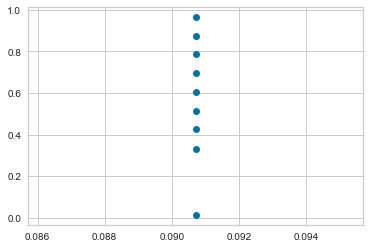

In [26]:
# Gráfica con la posición de cada uno de los elementos donde aquellos
# que no son resultados de búsqueda se muestran con un color distinto
groups = df_res.groupby("is_search_result")
for name, group in groups:
    plt.plot(group["x_position"], group["y_position"], marker="o", linestyle="", label=name)

In [27]:
# Muestra estadísticas sobre los items seleccionados, el ruido y los resultados de búsqueda encontrados
print("--------------- TOTAL DE LIST ITEMS ENCONTRADOS ---------------")
print(str(len(df_res[df_res['is_search_result'] == 1])) + '/' + str(total_items) + " - " + str("{:.2f}".format((len(df_res[df_res['is_search_result'] == 1])/total_items*100)) + "%"))
print("--------------- RUIDO (NO LIST ITEMS ENCONTRADOS) ---------------")
print(str(len(df_res[df_res['is_search_result'] == 0])) + '/' + str(len(df_res)) + " - " + str("{:.2f}".format(len(df_res[df_res['is_search_result'] == 0])/len(df_res)*100) + "%"))

--------------- TOTAL DE LIST ITEMS ENCONTRADOS ---------------
9/10 - 90.00%
--------------- RUIDO (NO LIST ITEMS ENCONTRADOS) ---------------
0/9 - 0.00%


In [28]:
# Nos quedamos con los xpaths de los elementos identificados, que podrán
# ser extraídos mediante su xpath en la aplicación que así lo necesite
df_res = df_res.drop(['dom_tree_level', 'x_position', 'height', 'width', 'html_children', 'html_attributes', 'padding_top', 'padding_right', 'padding_bottom', 'padding_left', 'margin_top', 'margin_right', 'margin_bottom', 'margin_left', 'y_position', 'cluster', 'reduced_xpath', 'is_search_result'], axis=1)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
df_res

,xpath
48,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[1]/div
89,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[3]/div
99,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[4]/div
109,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[5]/div
119,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[6]/div
129,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[7]/div
139,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[8]/div
149,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[9]/div
159,/html/body/div[1]/div[3]/div/div[2]/div[2]/div/div[2]/div[3]/div/div/div[1]/section[10]/div
